# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [1]:
import torch
from torch import nn
# from d2l import torch as d2l

In [2]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [3]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [4]:
loss = nn.CrossEntropyLoss(reduction='none')

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [5]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


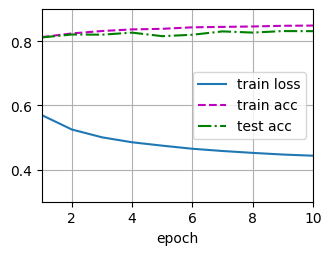

In [7]:
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？


[Discussions](https://discuss.d2l.ai/t/1793)
